In [1]:
import os

In [2]:
import matplotlib.pyplot as plt

In [3]:
def walk_through_dir(dir_path):
    """
    Walks through dir_path returning its contents.
    Args:
        dir_path (str or pathlib.Path): target directory
    
    Returns:
        A print out of:
            number of subdirectories in dir_path
            number of images (files) in each subdirectory
            name of each subdirectory
    """
    for dirpath,dirnames,filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

In [4]:
import requests
import zipfile
from pathlib import Path

In [5]:
data_path = Path(r"C:\Users\mohit\Downloads\DIP Assignment 2\Data_Q4")
image_path = data_path / "CXR_png"
masks_path = data_path / "masks"

In [6]:
walk_through_dir(image_path)

There are 0 directories and 801 images in C:\Users\mohit\Downloads\DIP Assignment 2\Data_Q4\CXR_png


In [7]:
#setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('C:/Users/mohit/Downloads/DIP Assignment 2/Data_Q4/CXR_png/train'),
 WindowsPath('C:/Users/mohit/Downloads/DIP Assignment 2/Data_Q4/CXR_png/test'))

In [8]:
import random
from PIL import Image

In [22]:
#set seed
random.seed(42)

#Get all image paths (* means 'any combination')
image_path_list = list(image_path.glob("*/*.png"))

#Get random image path
random_image_path = random.choice(image_path_list)

#Get image class from path name (name of directory)
image_class = random_image_path.parent.stem

#Open image
img = Image.open(random_image_path)

#Print metadata
print(f"Random Image Path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")

IndexError: list index out of range

In [9]:
#Transforming data into tensors, then into torch.utils.data.Dataset
import torch
from torch.utils.data import DataLoader
from torchvision import datasets,transforms

C:\Users\mohit\anaconda3\envs\tf-new\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
data_transform = transforms.Compose([transforms.ToPILImage(),
    #Resize the images to 572x572
    transforms.Resize(size = (128,128)),
    #turn the imahe into torch.Tensor
    transforms.ToTensor() #this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
    ])

In [11]:
def plot_transformed_images(image_paths, transform,n=3,seed=42):
    """Plots a series of random images from image_paths.
    
    Will open n image from image_paths, transform them with transform and
    plot them side by side
    
    Args:
        image_path (list): List of target image paths.
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int,optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths,k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1,2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis('off')
            
            #transform and plot the image
            #note: permute changes shape of image to suit matplotlib
            #Pytorch default is [C,H,W] but Matplotlib is [H,W,C]
            tensor_image = transforms.ToTensor()(f)
            transformed_image = transform(tensor_image).permute(1,2,0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis('off')
            
            fig.suptitle(f'Class: {image_path.parent.stem}' , fontsize = 16)
            
plot_transformed_images(image_path_list,transform = data_transform, n=3)

NameError: name 'image_path_list' is not defined

In [17]:
#Using ImageFolder to create datasets
from torchvision import datasets
train_data = datasets.ImageFolder(root = train_dir,
                                 transform = data_transform,
                                 target_transform = None)
test_data = datasets.ImageFolder(root = test_dir,
                                transform = data_transform)
print(f'Train data:\n{train_data}\nTest data:\n{test_data}')


FileNotFoundError: Couldn't find any class folder in C:\Users\mohit\Downloads\DIP Assignment 2\Q4_Data\CXR_png\train.

In [25]:
train_data.classes

['xray']

In [26]:
train_data.class_to_idx

{'xray': 0}

In [27]:
#defining U-Net parameters
NUM_CHANNELS = 1
NUM_CLASSES = 1
NUM_LEVELS = 3

#initialize learning rate, number of epochs to train for and batch size
INIT_LR = 0.001
NUM_EPOCHS = 15
BATCH_SIZE = 64

#define the input image dimensions
INPUT_IMAGE_WIDTH = 128
INPUT_IMAGE_HEIGHT = 128

#threshold to filter weak predictions
THRESHOLD = 0.5

#define path to the base output directory
BASE_OUTPUT = "output"

MODEL_PATH = os.path.join(BASE_OUTPUT,"unet_xray.pth")
PLOT_PATH = os.path.sep.join([BASE_OUTPUT,"plot.png"])
TEST_PATHS = os.path.sep.join([BASE_OUTPUT,"test_paths.txt"])

In [28]:
from torch.utils.data import Dataset
class SegmentationDataset(Dataset):
    def __init__(self,imagePaths,maskPaths,transforms):
        self.imagePaths = imagePaths
        self.maskPaths = maskPaths
        self.transforms = transforms
    
    def __len__(self):
        return len(self.imagePaths)
    def __getitem__(self,idx):
        imagePath = self.imagePaths[idx]
        
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.maskPaths[idx],0)
        
        if self.transforms is not None:
            image = self.transforms(image)
            mask = self.transforms(mask)
        
        return (image,mask)

In [29]:
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torchvision.transforms import CenterCrop
from torch.nn import functional as F

In [30]:
import cv2

In [31]:
class Block(Module):
    def __init__(self,inChannels,outChannels):
        super().__init__()
        self.conv1 = Conv2d(inChannels,outChannels,3)
        self.relu = ReLU()
        self.conv2 = Conv2d(outChannels,outChannels,3)
    
    def forward(self,x):
        return self.conv2(self.relu(self.conv1(x)))

In [32]:
class Encoder(Module):
    def __init__(self,channels = (3,16,32,64)):
        super().__init__()
        self.encBlocks = ModuleList([Block(
        channels[i],channels[i+1]) for i in range(len(channels)-1)])
        self.pool = MaxPool2d(2)
    
    def forward(self,x):
        blockOutputs = []
        for block in self.encBlocks:
            x = block(x)
            blockOutputs.append(x)
            x = self.pool(x)
        return blockOutputs

In [33]:
class Decoder(Module):
	def __init__(self, channels=(64, 32, 16)):
		super().__init__()
		# initialize the number of channels, upsampler blocks, and
		# decoder blocks
		self.channels = channels
		self.upconvs = ModuleList([ConvTranspose2d(channels[i], channels[i + 1], 2, 2) for i in range(len(channels) - 1)])
		self.dec_blocks = ModuleList([Block(channels[i], channels[i + 1]) for i in range(len(channels) - 1)])
        
	def forward(self, x, encFeatures):
		# loop through the number of channels
		for i in range(len(self.channels) - 1):
			# pass the inputs through the upsampler blocks
			x = self.upconvs[i](x)
			# crop the current features from the encoder blocks,
			# concatenate them with the current upsampled features,
			# and pass the concatenated output through the current
			# decoder block
			encFeat = self.crop(encFeatures[i], x)
			x = torch.cat([x, encFeat], dim=1)
			x = self.dec_blocks[i](x)
		# return the final decoder output
		return x
    
	def crop(self, encFeatures, x):
		# grab the dimensions of the inputs, and crop the encoder
		# features to match the dimensions
		(_, _, H, W) = x.shape
		encFeatures = CenterCrop([H, W])(encFeatures)
		# return the cropped features
		return encFeatures

In [34]:
class UNet(Module):
    def __init__(self,encChannels = (3,16,32,64),
    decChannels = (64,32,16),
    nbClasses =1,retainDim = True,
    outSize = (INPUT_IMAGE_HEIGHT,INPUT_IMAGE_WIDTH)):
        super().__init__()
        self.encoder = Encoder(encChannels)
        self.decoder = Decoder(decChannels)
        
        self.head = Conv2d(decChannels[-1],nbClasses,1)
        self.retainDim = retainDim
        self.outSize = outSize
        
    def forward(self,x):
        encFeatures = self.encoder(x)
        decFeatures = self.decoder(encFeatures[::-1][0],
                                  encFeatures[::-1][1:])
        map = self.head(decFeatures)
        
        if self.retainDim:
            map = F.interpolate(map,self.outSize)
            
        return map

In [35]:
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import time
import os
from torch import nn

In [36]:
imagePaths = sorted(list(paths.list_images(image_path)))
maskPaths = sorted(list(paths.list_images(masks_path)))

split = train_test_split(imagePaths,maskPaths,test_size = 0.25,random_state =42)

(trainImages,testImages) = split[:2]
(trainMasks,testMasks) = split[2:]

print("[INFO] saving testing image paths")
f = open(test_dir,"w")
f.write("\n".join(testImages))
f.close()

[INFO] saving testing image paths


In [37]:
trainDS = SegmentationDataset(imagePaths = trainImages, 
                              maskPaths = trainMasks, 
                              transforms = data_transform)
testDS = SegmentationDataset(imagePaths = testImages,
                              maskPaths = testMasks,
                              transforms = data_transform)

trainLoader = DataLoader(trainDS, shuffle = True, 
                        batch_size = BATCH_SIZE)
testLoader = DataLoader(testDS, shuffle = False, batch_size = BATCH_SIZE)


In [38]:
len(trainDS[0][0])

3

In [39]:
trainDS[0][0].size()

torch.Size([3, 128, 128])

trainDS

In [40]:
unet = UNet()
lossfn = BCEWithLogitsLoss()
optimizer  = Adam(unet.parameters(),lr = INIT_LR)

trainSteps = len(trainDS) // BATCH_SIZE
testSteps = len(testDS) // BATCH_SIZE

H = {"train_loss" :[], "test_loss" :[]}

In [41]:
startTime = time.time()
for e in tqdm(range(NUM_EPOCHS)):
    unet.train()
    totalTrainLoss = 0
    totalTestLoss = 0
    
    for (i,(x,y)) in enumerate(trainLoader):
        pred = unet(x)
        loss = lossfn(pred,y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        totalTrainLoss += loss
        
    with torch.inference_mode():
        unet.eval()
        
        for(x,y) in testLoader:
            pred = unet(x)
            
            totalTestLoss += lossfn(pred,y)
        
    avgTrainLoss = totalTrainLoss / trainSteps
    avgTestLoss = totalTestLoss / testSteps
    
    H["train_loss"].append(avgTrainLoss.detach().numpy())
    H["test_loss"].append(avgTestLoss.detach().numpy())
    
    print("EPOCH: {}/{}".format(e+1,NUM_EPOCHS))
    print("Train loss: {:,.6f},Test loss: {:.4f}".format(avgTrainLoss,avgTestLoss))
    
endTime = time.time()
print("[INFO] total time taken to train the model : {:.2f}s").format(endTime - startTime)

  7%|█████▍                                                                            | 1/15 [02:29<34:56, 149.75s/it]

EPOCH: 1/15
Train loss: 0.734736,Test loss: 0.7416


 13%|██████████▉                                                                       | 2/15 [05:03<32:57, 152.14s/it]

EPOCH: 2/15
Train loss: 0.606034,Test loss: 0.6996


 20%|████████████████▍                                                                 | 3/15 [07:37<30:38, 153.19s/it]

EPOCH: 3/15
Train loss: 0.593045,Test loss: 0.6943


 27%|█████████████████████▊                                                            | 4/15 [10:13<28:14, 154.01s/it]

EPOCH: 4/15
Train loss: 0.584120,Test loss: 0.6829


 33%|███████████████████████████▎                                                      | 5/15 [12:46<25:37, 153.71s/it]

EPOCH: 5/15
Train loss: 0.577546,Test loss: 0.6734


 40%|████████████████████████████████▊                                                 | 6/15 [15:20<23:03, 153.73s/it]

EPOCH: 6/15
Train loss: 0.564767,Test loss: 0.6624


 47%|██████████████████████████████████████▎                                           | 7/15 [17:55<20:32, 154.11s/it]

EPOCH: 7/15
Train loss: 0.558556,Test loss: 0.6485


 53%|███████████████████████████████████████████▋                                      | 8/15 [20:32<18:06, 155.21s/it]

EPOCH: 8/15
Train loss: 0.545131,Test loss: 0.6258


 60%|█████████████████████████████████████████████████▏                                | 9/15 [23:11<15:38, 156.38s/it]

EPOCH: 9/15
Train loss: 0.531916,Test loss: 0.6104


 67%|██████████████████████████████████████████████████████                           | 10/15 [25:49<13:04, 156.92s/it]

EPOCH: 10/15
Train loss: 0.532720,Test loss: 0.6120


 73%|███████████████████████████████████████████████████████████▍                     | 11/15 [28:27<10:28, 157.19s/it]

EPOCH: 11/15
Train loss: 0.511205,Test loss: 0.5941


 80%|████████████████████████████████████████████████████████████████▊                | 12/15 [30:59<07:46, 155.57s/it]

EPOCH: 12/15
Train loss: 0.502504,Test loss: 0.5841


 87%|██████████████████████████████████████████████████████████████████████▏          | 13/15 [33:32<05:09, 154.74s/it]

EPOCH: 13/15
Train loss: 0.479238,Test loss: 0.5476


 93%|███████████████████████████████████████████████████████████████████████████▌     | 14/15 [36:05<02:34, 154.39s/it]

EPOCH: 14/15
Train loss: 0.468646,Test loss: 0.5330


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [38:44<00:00, 154.98s/it]

EPOCH: 15/15
Train loss: 0.458341,Test loss: 0.5264
[INFO] total time taken to train the model : {:.2f}s


AttributeError: 'NoneType' object has no attribute 'format'

In [42]:
(endTime - startTime)/60 #minutes taken to train the model

38.74571882088979

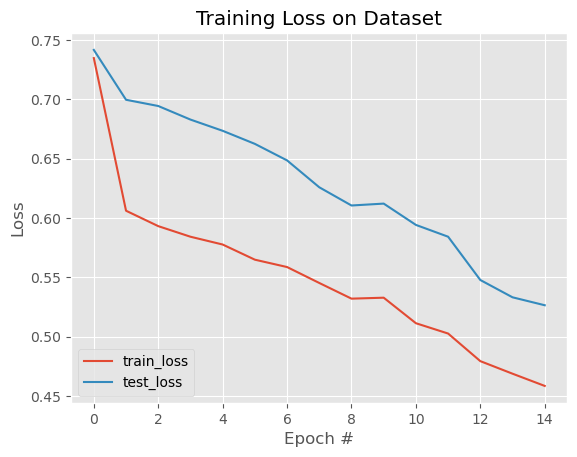

In [43]:
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"],label="train_loss")
plt.plot(H["test_loss"],label = "test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

In [44]:
torch.save(unet,MODEL_PATH)

FileNotFoundError: [Errno 2] No such file or directory: 'output\\unet_xray.pth'

Making Predictions

In [45]:
import numpy as np

In [105]:
def prepare_plot(origImage,predMask):
    figure, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10,10))
    
    ax[0].imshow(origImage, cmap='gray')
    #ax[1].imshow(origMask)
    ax[1].imshow(predMask,cmap='gray')
    
    ax[0].set_title("Image")
    #ax[1].set_title("Original Mask")
    ax[1].set_title("Predicted Mask")
    
    figure.tight_layout()
    figure.show()

(128, 128) (128, 128)


C:\Users\mohit\AppData\Local\Temp\ipykernel_37004\1921240287.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


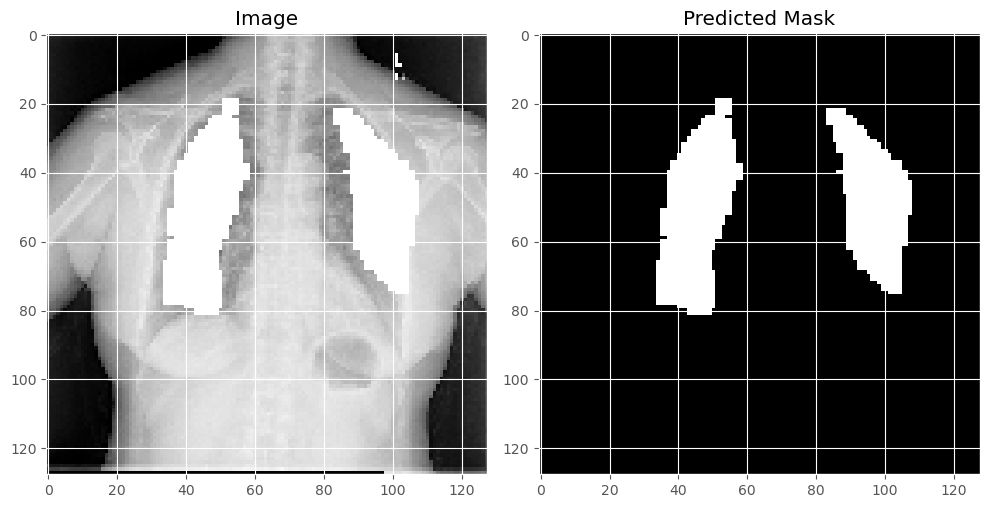

In [107]:
unet.eval()
    
with torch.inference_mode():
    image = cv2.imread(r"C:\Users\mohit\Downloads\DIP Assignment 2\Data_Q4\CXR_png\CHNCXR_0035_0.png")
    image_real = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    image_real = cv2.resize(image_real,(128,128))
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = image.astype("float32")/255.0
    image = cv2.resize(image,(128,128))
        
    orig = image.copy()
        
       # filename = imagePath.split(os.path.sep)[-1]
        #groundTruthPath = os.path.join(masks_path,filename)
        
        #gtMask = cv2.imread(groundTruthPath,0)
        #gtMask = cv2.resize(gtMask,(INPUT_IMAGE_HEIGHT,INPUT_IMAGE_WIDTH))
        
    image = np.transpose(image,(2,0,1)) #to get it to [C,H,W] format
    image = np.expand_dims(image,0) #model inputs 4 dimensional tensor
    image = torch.tensor(image)
        
    predMask = unet(image).squeeze() #to remove extra dimension
    predMask = torch.sigmoid(predMask)
    predMask = predMask.numpy()
        
    predMask = (predMask>THRESHOLD) *255
    predMask = predMask.astype(np.uint8)
        
#     prepare_plot(orig,predMask)
    print(image_real.shape, predMask.shape)
    for i in range(len(predMask)):
        for j in range(len(predMask[0])):
            if predMask[i][j] == 255:
                image_real[i][j] = 255

    prepare_plot(image_real,predMask)

In [118]:
image2 = cv2.imread(r"C:\Users\mohit\Downloads\DIP Assignment 2\Data_Q4\CXR_png\CHNCXR_0035_0.png")
image_real = cv2.cvtColor(image2,cv2.COLOR_BGR2GRAY)
image_real = cv2.resize(image_real,(128,128))

In [120]:
ROI = np.multiply(predMask,image_real)

In [121]:
ROI

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

(-0.5, 127.5, 127.5, -0.5)

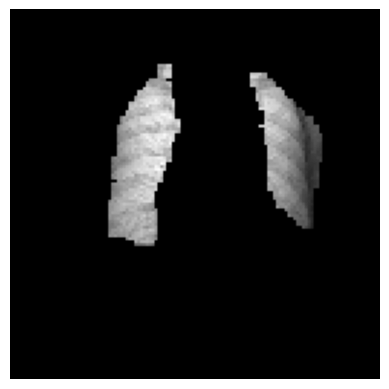

In [122]:
plt.imshow(ROI, cmap='gray')
plt.axis('off')